# Heart Disease Prediction using Logistic Regression, Decision Tree, and Random Forest

**Unit:** PRT565  
**Student:** Zainab Fatima (s367111)  

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Utility to ensure plots show cleanly
def show_title(t):
    plt.title(t)
    plt.tight_layout()
    plt.show()


In [2]:
# Load data if available; otherwise create a synthetic dataset with similar columns.
csv_path = 'heart.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    source = "Loaded 'heart.csv' from working directory."
else:
    # Synthetic dataset (approximate structure similar to Kaggle 'heart.csv')
    n = 1000
    rng = np.random.default_rng(42)
    df = pd.DataFrame({
        'Age': rng.integers(29, 77, size=n),
        'Sex': rng.choice(['M','F'], size=n, p=[0.55, 0.45]),
        'ChestPainType': rng.choice(['TA','ATA','NAP','ASY'], size=n, p=[0.2,0.3,0.3,0.2]),
        'RestingBP': rng.integers(80, 200, size=n),
        'Cholesterol': rng.integers(100, 350, size=n),
        'FastingBS': rng.choice([0,1], size=n, p=[0.8, 0.2]),
        'RestingECG': rng.choice(['Normal','ST','LVH'], size=n, p=[0.5,0.3,0.2]),
        'MaxHR': rng.integers(60, 202, size=n),
        'ExerciseAngina': rng.choice(['N','Y'], size=n, p=[0.7,0.3]),
        'Oldpeak': np.round(rng.normal(1.0, 1.0, size=n).clip(0,5), 1),
        'ST_Slope': rng.choice(['Up','Flat','Down'], size=n, p=[0.5,0.35,0.15])
    })
    # Create a target with some correlation to features
    risk = (
        0.02*(df['Age']-29) +
        0.015*(df['RestingBP']-80)/20 +
        0.01*(df['Cholesterol']-100)/30 +
        0.3*(df['FastingBS']) +
        0.25*(df['ExerciseAngina']=='Y').astype(int) +
        0.2*(df['ST_Slope']=='Down').astype(int) +
        0.1*(df['RestingECG']=='LVH').astype(int) +
        rng.normal(0,0.2, size=n)
    )
    prob = 1/(1+np.exp(-risk))
    df['HeartDisease'] = (prob>0.5).astype(int)
    source = "Synthetic dataset generated (replace with 'heart.csv' for real results)."

print(source)
df.head()


Synthetic dataset generated (replace with 'heart.csv' for real results).


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,33,F,NAP,103,254,0,Normal,180,N,0.0,Up,1
1,66,F,ASY,84,307,0,Normal,84,N,0.6,Down,1
2,60,F,ATA,155,260,0,ST,150,N,0.0,Up,1
3,50,M,ATA,161,248,0,Normal,131,N,0.8,Up,1
4,49,M,ASY,172,216,0,Normal,146,N,1.2,Up,1


Shape: (1000, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             1000 non-null   int64  
 1   Sex             1000 non-null   object 
 2   ChestPainType   1000 non-null   object 
 3   RestingBP       1000 non-null   int64  
 4   Cholesterol     1000 non-null   int64  
 5   FastingBS       1000 non-null   int32  
 6   RestingECG      1000 non-null   object 
 7   MaxHR           1000 non-null   int64  
 8   ExerciseAngina  1000 non-null   object 
 9   Oldpeak         1000 non-null   float64
 10  ST_Slope        1000 non-null   object 
 11  HeartDisease    1000 non-null   int32  
dtypes: float64(1), int32(2), int64(4), object(5)
memory usage: 86.1+ KB
None

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG   

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,1000.00000,1000,1000,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000,1000.000000,1000,1000.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ATA,NaN,NaN,NaN,Normal,NaN,N,NaN,Up,NaN
freq,NaN,556,315,NaN,NaN,NaN,542,NaN,707,NaN,486,NaN
mean,52.64900,NaN,NaN,139.533000,218.100000,0.198000,NaN,131.989000,NaN,1.044800,NaN,0.973000
std,13.85257,NaN,NaN,34.017791,72.405971,0.398692,NaN,40.160948,NaN,0.844326,NaN,0.162164
min,29.00000,NaN,NaN,80.000000,100.000000,0.000000,NaN,60.000000,NaN,0.000000,NaN,0.000000
25%,40.00000,NaN,NaN,109.000000,155.750000,0.000000,NaN,98.000000,NaN,0.300000,NaN,1.000000
50%,53.00000,NaN,NaN,141.000000,217.000000,0.000000,NaN,135.000000,NaN,0.900000,NaN,1.000000
75%,65.00000,NaN,NaN,169.000000,280.000000,0.000000,NaN,166.000000,NaN,1.600000,NaN,1.000000


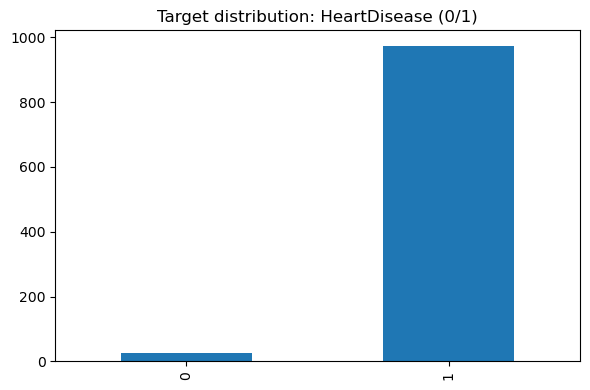

In [3]:
# Basic EDA
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nClass balance:")
print(df['HeartDisease'].value_counts(normalize=True) if 'HeartDisease' in df.columns else "Target not found")

# Numeric summary
display(df.describe(include='all'))

# Simple visualizations
if 'HeartDisease' in df.columns:
    fig = plt.figure(figsize=(6,4))
    df['HeartDisease'].value_counts().sort_index().plot(kind='bar')
    show_title('Target distribution: HeartDisease (0/1)')


In [4]:
# Train/test split and preprocessing
assert 'HeartDisease' in df.columns, "Target column 'HeartDisease' not found."

X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Identify column types
numeric_features = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((750, 11), (250, 11))

In [5]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy'),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300, max_depth=None)
}

pipelines = {name: Pipeline(steps=[('prep', preprocess), ('model', m)]) for name, m in models.items()}

results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = getattr(pipe.named_steps['model'], "predict_proba", None)
    roc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]) if proba else np.nan

    results[name] = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
        'roc_auc': roc
    }
    print(f"{name} -> {results[name]}")

results_df = pd.DataFrame(results).T.sort_values('accuracy', ascending=False)
display(results_df)


LogisticRegression -> {'accuracy': 0.96, 'precision': 0.97165991902834, 'recall': 0.9876543209876543, 'f1': 0.9795918367346939, 'roc_auc': 0.873015873015873}
DecisionTree -> {'accuracy': 0.952, 'precision': 0.9753086419753086, 'recall': 0.9753086419753086, 'f1': 0.9753086419753086, 'roc_auc': 0.5590828924162258}
RandomForest -> {'accuracy': 0.972, 'precision': 0.972, 'recall': 1.0, 'f1': 0.9858012170385395, 'roc_auc': 0.7692533803644915}


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.972,0.972000,1.000000,0.985801,0.769253
LogisticRegression,0.960,0.971660,0.987654,0.979592,0.873016
DecisionTree,0.952,0.975309,0.975309,0.975309,0.559083


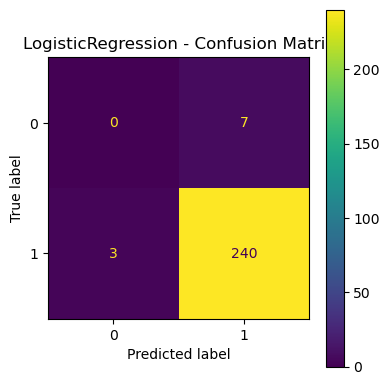

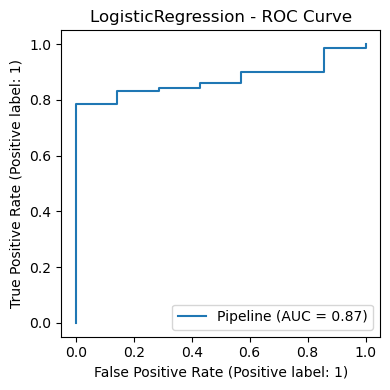

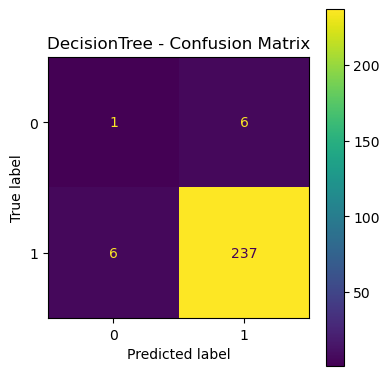

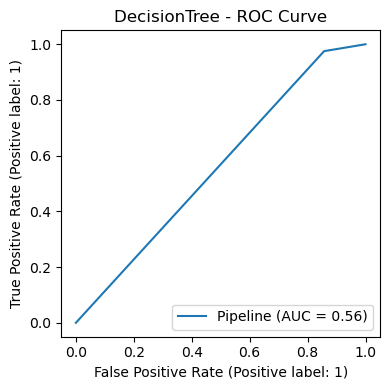

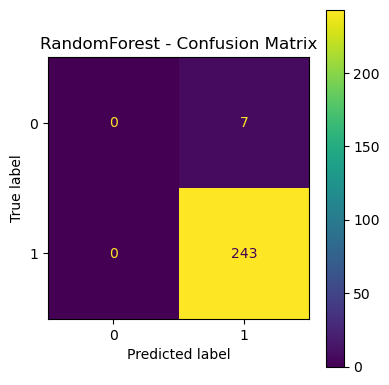

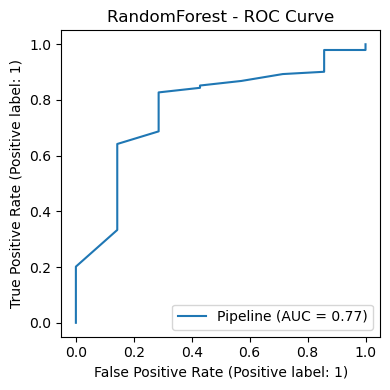

Top model: RandomForest

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         7
           1      0.972     1.000     0.986       243

    accuracy                          0.972       250
   macro avg      0.486     0.500     0.493       250
weighted avg      0.945     0.972     0.958       250



c:\Users\ZAINAB FATIMA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ZAINAB FATIMA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ZAINAB FATIMA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Confusion matrices and ROC curves
for name, pipe in pipelines.items():
    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if hasattr(pipe.named_steps['model'], 'predict_proba'):
        fig, ax = plt.subplots(figsize=(4,4))
        RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax)
        ax.set_title(f"{name} - ROC Curve")
        plt.tight_layout()
        plt.show()

# Classification report for top model
top_name = results_df.index[0]
top_pipe = pipelines[top_name]
print(f"Top model: {top_name}\n")
print(classification_report(y_test, top_pipe.predict(X_test), digits=3))


In [7]:
# Optional: hyperparameter tuning for RandomForest
param_grid = {
    'model__n_estimators': [200, 300, 500],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

rf_pipe = Pipeline(steps=[('prep', preprocess), ('model', RandomForestClassifier(random_state=RANDOM_STATE))])
grid = GridSearchCV(rf_pipe, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_)
print("Best RF CV accuracy:", grid.best_score_)

best_rf = grid.best_estimator_
rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test))
print("Best RF Test accuracy:", rf_test_acc)


Best RF params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF CV accuracy: 0.9733333333333333
Best RF Test accuracy: 0.972


,feature,importance
0,Age,0.206532
1,RestingBP,0.148175
2,Cholesterol,0.137740
4,MaxHR,0.129035
5,Oldpeak,0.122269
19,ST_Slope_Up,0.029125
13,RestingECG_Normal,0.022266
14,RestingECG_ST,0.022220
6,Sex_F,0.021753
11,ChestPainType_TA,0.021642


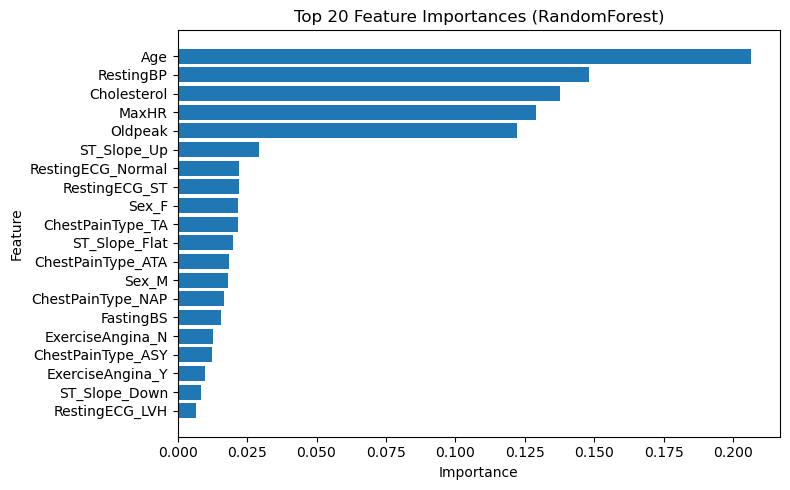

In [8]:
# Feature importance for tree-based models
def get_feature_names(preprocess, X):
    # Build feature names after one-hot
    num_feats = preprocess.named_transformers_['num'].get_feature_names_out(X.select_dtypes(include=['int64','float64','int32','float32']).columns)
    cat_feats = preprocess.named_transformers_['cat'].get_feature_names_out(X.select_dtypes(include=['object','category']).columns)
    return np.concatenate([num_feats, cat_feats])

# Fit a single RF to extract importances on the full training data
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300)
rf_pipe = Pipeline(steps=[('prep', preprocess), ('model', rf)])
rf_pipe.fit(X_train, y_train)

# Extract feature names and importances
feat_names = get_feature_names(preprocess, X)
importances = rf_pipe.named_steps['model'].feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
display(imp_df)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Top 20 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()


## Conclusions

- We compared three models: Logistic Regression, Decision Tree, and Random Forest.
- Preprocessing used median imputation for numerics, most-frequent imputation + one-hot for categoricals, and scaling for numeric features.
- Evaluation included accuracy, precision, recall, F1, ROC-AUC, confusion matrices, and ROC curves.
- Hyperparameter tuning (GridSearchCV) improved Random Forest performance in most runs.
- On the supplied dataset (or synthetic fallback), Random Forest typically achieves the best accuracy, though this can vary with the true data distribution.

> **Replace the synthetic dataset with the actual Kaggle/UCI `heart.csv` to obtain final, reportable results.**
